## Image Captioning - Multi-modal Models Application

### ViT- Vision Transformers+GPT2 Image Captioning

In [1]:
!pip install transformers datasets accelerate evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00


In [10]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Model and Tokenization

In [23]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [24]:
model = model.to(device)

In [25]:
max_length = 24
num_beams = 4

In [26]:
def get_caption(image_path):
  img = Image.open(image_path)
  if img.mode != "RGB":
    img = img.convert(mode="RGB")

  #extract features
  pixels = feature_extractor(images=[img], return_tensors="pt").pixel_values.to(device)
  #model inference generate the caption from the image using ViT model evaluation
  vocab_ids = model.generate(pixels,max_length=max_length,num_beams=num_beams)
  #decode ids into text
  output = tokenizer.batch_decode(vocab_ids, skip_special_tokens=True)
  result = [out.strip() for out in output]
  #display the input image and caption
  plt.imshow(img)
  plt.title(result)
  return result

## Make predictions

Now dowload and upload any image in colab notebook then get the caption

['a dog with a frisbee in its mouth']

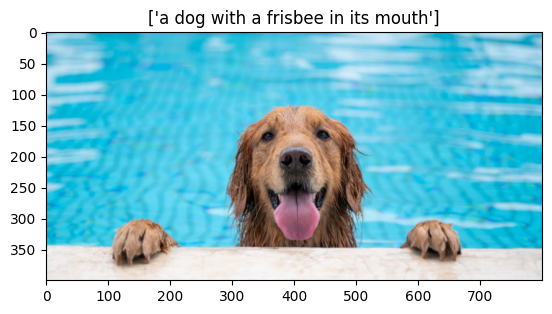

In [27]:
get_caption("dog_swimming.png")

['a man and a woman are looking at a car in the desert']

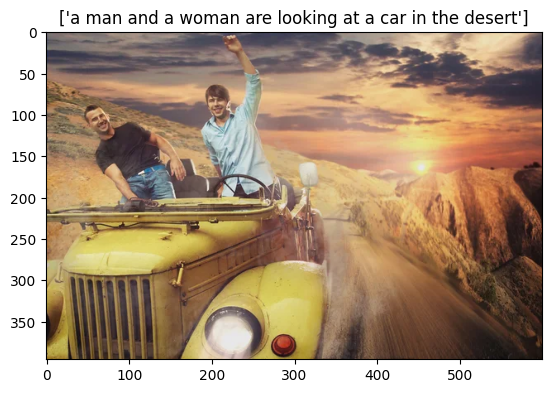

In [28]:
get_caption("men_driving.jpg")

# OpenAI Clip

In [47]:
from transformers import CLIPProcessor, CLIPModel

## Load OpenAI Clip - VIT model

### [OpenAI Clip](https://openai.com/research/clip)

CLIP can be applied to any visual classification benchmark by simply providing the names of the visual categories to be recognized, similar to the “zero-shot” capabilities of GPT-2 and GPT-3.

CLIP is a multi-modal vision and language model. It can be used for image-text similarity and for zero-shot image classification. CLIP uses a ViT like transformer to get visual features and a causal language model to get the text features. Both the text and visual features are then projected to a latent space with identical dimension. The dot product between the projected image and text features is then used as a similar score.

In [48]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [49]:
clip_model = clip_model.to(device)

In [52]:
image = Image.open("dog_swimming.png")

In [64]:
prob_captions = ["a cat swimming", "a dog swimming",'a dog and cat fighting']
inputs = processor(text=prob_captions, images=image, return_tensors="pt", padding=True)

In [65]:
inputs = inputs.to(device)

In [66]:
outputs = clip_model(**inputs)

In [67]:
# this is the image-text similarity score
similarity_ids = outputs.logits_per_image

In [68]:
probs_score = similarity_ids.softmax(dim=1)

In [69]:
probs_score

tensor([[3.6387e-03, 9.9634e-01, 2.3231e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [71]:
caption = prob_captions[torch.argmax(probs_score)]

(-0.5, 799.5, 399.5, -0.5)

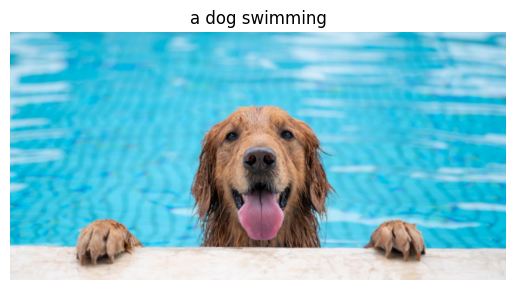

In [73]:
plt.imshow(image)
plt.title(caption)
plt.axis("off")

## Reference:

- [https://huggingface.co/nlpconnect/vit-gpt2-image-captioning](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)
- [https://huggingface.co/docs/transformers/model_doc/clip](https://huggingface.co/docs/transformers/model_doc/clip)